# Proyecto de Simulacion SIR Secuencial

### Setup Inicial de la Prueba

In [120]:
#Importando librerias para la simulación
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation


#Creando las constantes del modelo
gridSize = 100
dias = 365

contagioRate = 0.25 #funciona con porcentajes
recoveryRate = 0.18

#Colores para la visualizacion
Colors = ['lightblue', 'red','darkgreen']
cmap = ListedColormap(Colors)

#Estados
Suceptible = 0
Infectado = 1
Removido = 2

#Cantidad de Infectados al Principio
cantInf = 2


### Insertación de los Infectados

In [121]:
def inicializar_grid (size, infectados_iniciales):
    grid = np.full((size,size), Suceptible, dtype=np.int8)

    timer_infectado = np.zeros((size, size), dtype=np.int8)

    center = size//2
    for i in range(infectados_iniciales):
        row = center + random.randint(-2,2)
        col = center + random.randint(-2,2)
        if 0 <= row < size and 0 <= col < size:
            grid[row, col] = Infectado
            timer_infectado[row, col] = recoveryRate
    print(f"Grid Initialized: {size}x{size}, {np.sum(grid == Infectado)} infectados iniciales.")
    return grid, timer_infectado


### Actualización secuencial de la simulación

In [122]:
def actualizar_secuencial(grid, infection_timer, P_INFECTION, DAYS_INFECTED):
    size = grid.shape[0]

    new_grid = grid.copy()
    new_infection_timer = infection_timer.copy()

    new_infections_count = 0

    for i in range(size):
        for j in range(size):
            current_state = grid[i, j]

            if current_state == Infectado:
                # Decrementa el contador.
                if random.random() < recoveryRate:
                    new_grid[i,j] = Removido

                #new_infection_timer[i, j] -= 1

                # Si el contador llega a 0, el individuo se recupera
                #if new_infection_timer[i, j] <= 0:
                #    new_grid[i, j] = Removido
                #   new_infection_timer[i, j] = 0 # Aseguramos que se reinicie

            elif current_state == Suceptible:
                # Comprueba los 8 vecinos (vecindario de Moore)
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        if di == 0 and dj == 0:
                            continue # No es vecino, es la celda actual

                        ni, nj = i + di, j + dj # Coordenadas del vecino

                        # 1. Asegurar que las coordenadas del vecino sean válidas
                        if 0 <= ni < size and 0 <= nj < size:
                            # 2. Comprobar si el vecino está Infectado
                            if grid[ni, nj] == Infectado:
                                # 3. Intento de Infección con Probabilidad P_INFECTION
                                if random.random() < P_INFECTION:
                                    # ¡La infección ocurre!
                                    new_grid[i, j] = Infectado
                                    new_infection_timer[i, j] = DAYS_INFECTED
                                    new_infections_count += 1
                                    # Rompemos los loops de vecinos: un individuo solo se puede infectar una vez por día
                                    # (no tiene sentido comprobar más vecinos si ya se infectó)
                                    break
                    # Si ya se infectó en el inner loop, rompemos el outer loop también
                    if new_grid[i, j] == Infectado:
                        break

    return new_grid,  new_infections_count


### Simulación principal y Recolección de Estadisticas

In [123]:
def simul_secuencial(size, days, initial_infected, p_infection, p_recovery):
    grid, infection_timer = inicializar_grid(size, initial_infected)

    grid_history = [grid.copy()]
    stats_history = []

    infect_acumulado = 0

    for day in range(1, days + 1):
        grid, new_infections = actualizar_secuencial(
            grid, infection_timer, p_infection, p_recovery
        )
    
        S = np.sum(grid == Suceptible)
        I = np.sum(grid == Infectado)
        R = np.sum(grid == Removido)
        N = S+I+R

        infect_acumulado += new_infections

        R0_proxy = new_infections / I if I > 0 else 0
        stats_history.append({
                'day': day,
                'susceptible': S,
                'infected': I,
                'recovered': R,
                'total_infected_accumulated': infect_acumulado,
                'R0_proxy': R0_proxy
        })

        grid_history.append(grid.copy())

        if I == 0 and infect_acumulado > 0:
            print(f"Brote terminado el día {day}.")
            break
        
    return grid_history, stats_history

### Creación de la Animación de los Gráficos

In [124]:
def create_animation(grid_history, output_filename="brote_secuencial.gif"):
    print(print(f"\n--- Generando animación de {len(grid_history)} frames ---"))
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(f"Día 0")

    im = ax.imshow(grid_history[0], cmap=cmap, vmin=Suceptible, vmax=Removido)
    ax.set_xticks([])
    ax.set_yticks([])

    def update(frame_number):
        im.set_array(grid_history[frame_number])
        ax.set_title(f"Día {frame_number}")
        return [im]

    # Crear la animación
    anim = FuncAnimation(
        fig, 
        update, 
        frames=len(grid_history), 
        interval=200, # 200 ms entre frames
        blit=True
    )
    
    try:
        # Se requiere la librería Pillow para guardar como GIF
        anim.save(output_filename, writer='pillow', fps=5) 
        print(f"Animación guardada como {output_filename}")
    except Exception as e:
        print(f"Error al guardar la animación (¿Falta 'Pillow' o 'ImageIO'?): {e}")

    plt.close(fig)

### Ejecución de Simulación y Validación

--Ejecutando Simulación Secuencial--
Grid Initialized: 100x100, 1 infectados iniciales.
Brote terminado el día 112.

--- Generando animación de 113 frames ---
None
Animación guardada como brote_secuencial.gif


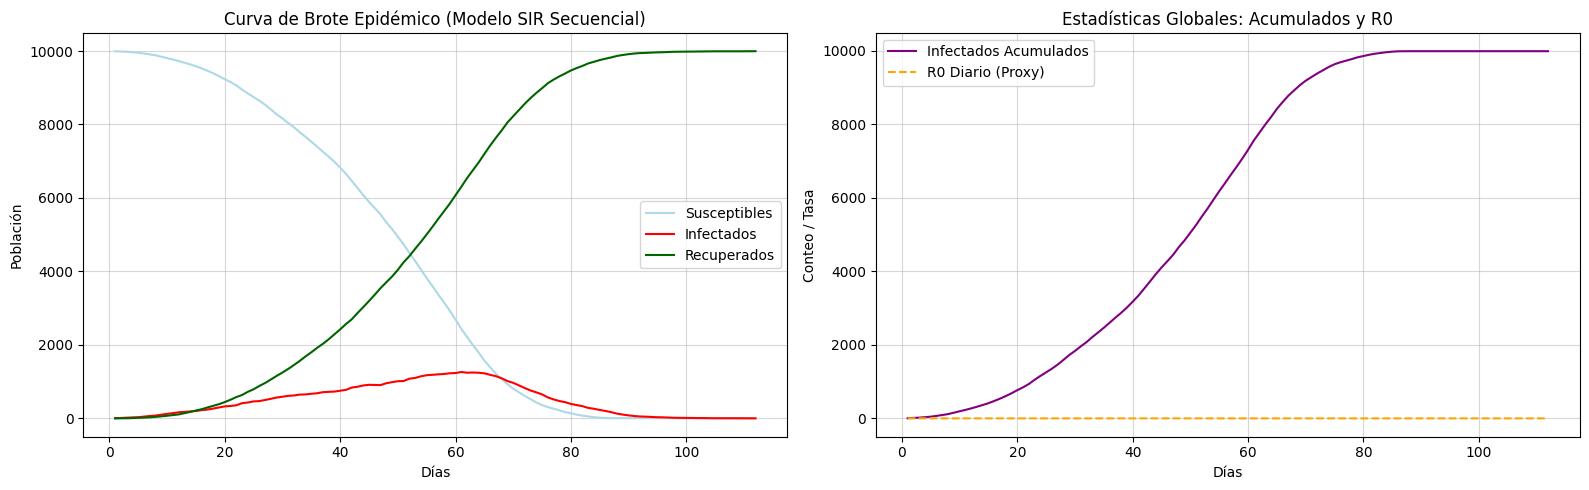


--- Validación del Requisito 1 completada ---
Pico de Infectados: 1262 personas
Total de Infectados Acumulados: 9994 personas


In [125]:
print("--Ejecutando Simulación Secuencial--")
grid_history_seq, stats_history_seq = simul_secuencial(
    gridSize, dias, cantInf, contagioRate, recoveryRate
)

create_animation(grid_history_seq)

stats_df = np.array([s['infected'] for s in stats_history_seq])

days_simulated = len(stats_history_seq)
days_axis = range(1, days_simulated + 1)
S_data = [s['susceptible'] for s in stats_history_seq]
I_data = [s['infected'] for s in stats_history_seq]
R_data = [s['recovered'] for s in stats_history_seq]
R0_data = [s['R0_proxy'] for s in stats_history_seq]
Accumulated_data = [s['total_infected_accumulated'] for s in stats_history_seq]

fig, axs = plt.subplots(1,2,figsize=(16,5))

axs[0].plot(days_axis, S_data, label='Susceptibles', color='lightblue')
axs[0].plot(days_axis, I_data, label='Infectados', color='red')
axs[0].plot(days_axis, R_data, label='Recuperados', color='darkgreen')
axs[0].set_title('Curva de Brote Epidémico (Modelo SIR Secuencial)')
axs[0].set_xlabel('Días')
axs[0].set_ylabel('Población')
axs[0].legend()
axs[0].grid(True, alpha=0.5)

axs[1].plot(days_axis, Accumulated_data, label='Infectados Acumulados', color='purple', linestyle='-')
axs[1].plot(days_axis, R0_data, label='R0 Diario (Proxy)', color='orange', linestyle='--')
axs[1].set_title('Estadísticas Globales: Acumulados y R0')
axs[1].set_xlabel('Días')
axs[1].set_ylabel('Conteo / Tasa')
axs[1].legend()
axs[1].grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

print("\n--- Validación del Requisito 1 completada ---")
print(f"Pico de Infectados: {max(I_data)} personas")
print(f"Total de Infectados Acumulados: {Accumulated_data[-1]} personas")